In [193]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, median_absolute_error
from scipy import stats

In [5]:
abbrev = pd.read_csv("data/abbrev.csv")
abbrev.columns

Index(['Unnamed: 0', 'household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population',
       'pop_65_plus', 'health_ins', 'county', 'state', 'area', 'prc_obese',
       'domestic_passengers', 'intl_passengers', 'deaths', 'cases_march1',
       'cases_march15', 'cases_april1', 'ten_plus', 'order', 'density',
       'death_prc'],
      dtype='object')

In [6]:
abbrev = abbrev.drop('Unnamed: 0', axis=1)

In [7]:
predictors = ['household_size', 'empl_agriculture', 'empl_professional','empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
              'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population', 'pop_65_plus', 'health_ins', 'area', 
              'domestic_passengers', 'intl_passengers', 'prc_obese', 'ten_plus', 'order', 'density', 'cases_march1',
             'cases_march15']
# omitting april1 cases data, since it's pretty much perfectly correlated...

predictors_noCaseData = predictors.copy()
predictors_noCaseData.remove('cases_march1')
predictors_noCaseData.remove('cases_march15')
predictors_noCaseData

['household_size',
 'empl_agriculture',
 'empl_professional',
 'empl_social',
 'empl_services',
 'empl_manufacturing',
 'empl_retail',
 'prc_fam_poverty',
 'avg_income',
 'prc_public_transp',
 'population',
 'pop_65_plus',
 'health_ins',
 'area',
 'domestic_passengers',
 'intl_passengers',
 'prc_obese',
 'ten_plus',
 'order',
 'density']

In [8]:
abbrev.loc[abbrev["intl_passengers"] == 0, "intl_passengers"] = 0.0000001
abbrev.loc[abbrev["domestic_passengers"] == 0, "domestic_passengers"] = 0.0000001
abbrev.loc[abbrev["cases_march1"] == 0, "cases_march1"] = 0.0000001
abbrev.loc[abbrev["cases_march15"] == 0, "cases_march15"] = 0.0000001

transform = ["population", "density", "intl_passengers", "domestic_passengers", "area", 
            "cases_march1", "cases_march15"]
for field in transform:
    abbrev["log_"+field] = np.log1p(abbrev[field])

In [10]:
log_predictors = predictors.copy()
for field in transform:
    log_predictors.remove(field)
    log_predictors.append("log_"+field)
print(log_predictors)

['household_size', 'empl_agriculture', 'empl_professional', 'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail', 'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'pop_65_plus', 'health_ins', 'prc_obese', 'ten_plus', 'order', 'log_population', 'log_density', 'log_intl_passengers', 'log_domestic_passengers', 'log_area', 'log_cases_march1', 'log_cases_march15']


In [11]:
log_predictors_noCaseData = log_predictors.copy()
log_predictors_noCaseData.remove('log_cases_march1')
log_predictors_noCaseData.remove('log_cases_march15')
print(log_predictors_noCaseData)

['household_size', 'empl_agriculture', 'empl_professional', 'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail', 'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'pop_65_plus', 'health_ins', 'prc_obese', 'ten_plus', 'order', 'log_population', 'log_density', 'log_intl_passengers', 'log_domestic_passengers', 'log_area']


In [12]:
import re
def get_col_name(feature_set, name):
    number = re.compile("x(\d+)")
    matched = number.match(name)
    if matched:
        n = int(matched.group(1))
        col_name = feature_set[n]
    else:
        col_name = "X"
    return col_name

def transform_name(feature_set, name):
    interaction = re.compile("(\w+) (\w+)")
    matched = interaction.match(name)
    col_name = ""
    if matched:
        name1 = get_col_name(feature_set, matched.group(1))
        name2 = get_col_name(feature_set, matched.group(2))
        col_name = name1 + ":" + name2
    else:
        col_name = get_col_name(feature_set, name)
    return col_name

In [13]:
poly = PolynomialFeatures(interaction_only=True)
scaler = StandardScaler()
# https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia
# https://stats.stackexchange.com/questions/25690/multiple-linear-regression-for-hypothesis-testing#25707

scaler.fit(abbrev[predictors])
inter = pd.DataFrame(poly.fit_transform(scaler.transform(abbrev[predictors])), 
                     columns=[transform_name(predictors, x) for x in poly.get_feature_names()])

scaler.fit(abbrev[predictors_noCaseData])
inter_noCases = pd.DataFrame(poly.fit_transform(scaler.transform(abbrev[predictors_noCaseData])), 
                             columns=[transform_name(predictors_noCaseData, x) for x in poly.get_feature_names()])

scaler.fit(abbrev[log_predictors])
inter_log = pd.DataFrame(poly.fit_transform(scaler.transform(abbrev[log_predictors])), 
                         columns=[transform_name(log_predictors, x) for x in poly.get_feature_names()])

scaler.fit(abbrev[log_predictors_noCaseData])
inter_log_noCases = pd.DataFrame(poly.fit_transform(scaler.transform(abbrev[log_predictors_noCaseData])), 
                                 columns=[transform_name(log_predictors_noCaseData, x) for x in poly.get_feature_names()])

In [14]:
inter = inter.drop("X", axis=1)
inter_noCases = inter_noCases.drop("X", axis=1)
inter_log = inter_log.drop("X", axis=1)
inter_log_noCases = inter_log_noCases.drop("X", axis=1)

### Linear Regression

In [15]:
# dependent variable = deaths

lrm_noCases = LinearRegression().fit(abbrev[predictors_noCaseData], abbrev["deaths"])
lrm = LinearRegression().fit(abbrev[predictors], abbrev["deaths"])
lrm_log_noCases = LinearRegression().fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])
lrm_log = LinearRegression().fit(abbrev[log_predictors], abbrev["deaths"])

lrm_int_noCases = LinearRegression().fit(inter_noCases, abbrev["deaths"])
lrm_int = LinearRegression().fit(inter, abbrev["deaths"])
lrm_int_log_noCases = LinearRegression().fit(inter_log_noCases, abbrev["deaths"])
lrm_int_log = LinearRegression().fit(inter_log, abbrev["deaths"])

print("no case data R2: ", lrm_noCases.score(abbrev[predictors_noCaseData], abbrev["deaths"]), 
      "\nwith case data R2: ", lrm.score(abbrev[predictors], abbrev["deaths"]), 
      "\nlog predictors no case data R2: ", lrm_log_noCases.score(abbrev[log_predictors_noCaseData], abbrev["deaths"]), 
      "\nlog predictors with case data R2: ", lrm_log.score(abbrev[log_predictors], abbrev["deaths"]), 
      "\nno case data with interactions: ", lrm_int_noCases.score(inter_noCases, abbrev["deaths"]),
      "\nwith case data, with interactions: ", lrm_int.score(inter, abbrev["deaths"]),
      "\nlog predictors, no case data, with interactions: ", lrm_int_log_noCases.score(inter_log_noCases, abbrev["deaths"]), 
      "\nlog predictors, with case data, with interactions: ", lrm_int_log.score(inter_log, abbrev["deaths"])
     )

# some spectacular over-fitting!

no case data R2:  0.5409614115483582 
with case data R2:  0.7292119630161213 
log predictors no case data R2:  0.3470212945681367 
log predictors with case data R2:  0.3611453977701736 
no case data with interactions:  0.9935560655557009 
with case data, with interactions:  0.9962878948524558 
log predictors, no case data, with interactions:  0.949686240008907 
log predictors, with case data, with interactions:  0.9749078657702694


In [16]:
for a, b in zip(inter_log_noCases.columns, lrm_int_log_noCases.coef_):
    if (b > 1000) or (b < -1000):
        print(a, "\t", b)

log_population 	 -7678.986678364605
log_density 	 10336.237507498914
log_area 	 7418.730974999337
household_size:log_population 	 1708.229110106571
household_size:log_density 	 -2291.132989141547
household_size:log_area 	 -1628.4836681934676
empl_agriculture:log_population 	 2771.4777919723633
empl_agriculture:log_density 	 -3714.8011990350997
empl_agriculture:log_area 	 -2658.330051114356
empl_professional:log_population 	 1461.546553879926
empl_professional:log_density 	 -1991.5151240129132
empl_professional:log_area 	 -1425.0311912932643
empl_social:log_population 	 2069.593342796797
empl_social:log_density 	 -2843.868919158772
empl_social:log_area 	 -2033.2374227619475
empl_services:log_population 	 1782.5635421842508
empl_services:log_density 	 -2379.5976203266846
empl_services:log_area 	 -1701.8729531338688
prc_fam_poverty:log_population 	 -1543.9090740737956
prc_fam_poverty:log_density 	 2058.5587651842893
prc_fam_poverty:log_area 	 1485.40894950551
avg_income:log_population 	 -

#### Linear Regression with TransformedTargetRegressor

transforms the dependent variable (here using natural logarithm) before regression

+ https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
+ https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#sklearn.compose.TransformedTargetRegressor

In [18]:
ttr = TransformedTargetRegressor(regressor=LinearRegression(), 
                                 func=np.log1p, inverse_func=np.expm1)

ttr.fit(abbrev[predictors_noCaseData], abbrev["deaths"])
ttr_lrm_noCases = ttr.score(abbrev[predictors_noCaseData], abbrev["deaths"])

ttr.fit(abbrev[predictors], abbrev["deaths"])
ttr_lrm = ttr.score(abbrev[predictors], abbrev["deaths"])

ttr.fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])
ttr_log_lrm_noCases = ttr.score(abbrev[log_predictors_noCaseData], abbrev["deaths"])

ttr.fit(abbrev[log_predictors], abbrev["deaths"])
ttr_log_lrm = ttr.score(abbrev[log_predictors], abbrev["deaths"])

ttr.fit(inter_noCases, abbrev["deaths"])
ttr_inter_noCases = ttr.score(inter_noCases, abbrev["deaths"])

ttr.fit(inter, abbrev["deaths"])
ttr_inter = ttr.score(inter, abbrev["deaths"])

ttr.fit(inter_log_noCases, abbrev["deaths"])
ttr_inter_log_noCases = ttr.score(inter_log_noCases, abbrev["deaths"])

ttr.fit(inter_log, abbrev["deaths"])
ttr_inter_log = ttr.score(inter_log, abbrev["deaths"])


print("with transformed target (using ln)\nno case data R2: ", ttr_lrm_noCases, 
      "\nwith case data R2: ", ttr_lrm, 
      "\nlog predictors no case data R2: ", ttr_log_lrm_noCases, 
      "\nlog predictors with case data R2: ", ttr_log_lrm, 
      "\nno case data with interactions: ", ttr_inter_noCases,
      "\nwith case data, with interactions: ", ttr_inter,
      "\nlog predictors, no case data, with interactions: ", ttr_inter_log_noCases, 
      "\nlog predictors, with case data, with interactions: ", ttr_inter_log)


with transformed target (using ln)
no case data R2:  -8.151688461559898 
with case data R2:  -29.94517595783297 
log predictors no case data R2:  0.8052465912711629 
log predictors with case data R2:  0.9217995123708174 
no case data with interactions:  0.9941960281713147 
with case data, with interactions:  0.9951723567718955 
log predictors, no case data, with interactions:  0.9884770791778326 
log predictors, with case data, with interactions:  0.9890028371046773


In [20]:
# compare those with with r2=.910 and r2=0.799 (log predictors, dependent variable=deaths)
ttr1 = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
ttr1.fit(inter_log_noCases, abbrev["deaths"])

ttr2 = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
ttr2.fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])

TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log1p'>,
                           inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           transformer=None)

In [25]:
exam = abbrev.copy()
exam["fitted_inter"] = ttr1.regressor_.predict(inter_log_noCases)
exam["pred_inter"] = ttr1.inverse_func(ttr1.regressor_.predict(inter_log_noCases))

exam["fitted"] = ttr2.regressor_.predict(abbrev[log_predictors_noCaseData])
exam["pred"] = ttr2.inverse_func(ttr2.regressor_.predict(abbrev[log_predictors_noCaseData]))

In [27]:
exam[["pred", "pred_inter", "deaths"]].describe()

,pred,pred_inter,deaths
count,823.000000,823.000000,823.000000
mean,21.328873,32.935364,38.071689
std,235.360215,404.262825,408.374275
min,-0.692413,-0.454685,0.000000
25%,1.545885,1.316806,1.000000
50%,3.783330,3.377938,3.000000
75%,9.147288,9.222401,13.000000
max,6674.896016,11419.347956,11477.000000


In [29]:
import rpy2.robjects as robjects
%load_ext rpy2.ipython

R[write to console]: `geom_smooth()` using formula 'y ~ x'



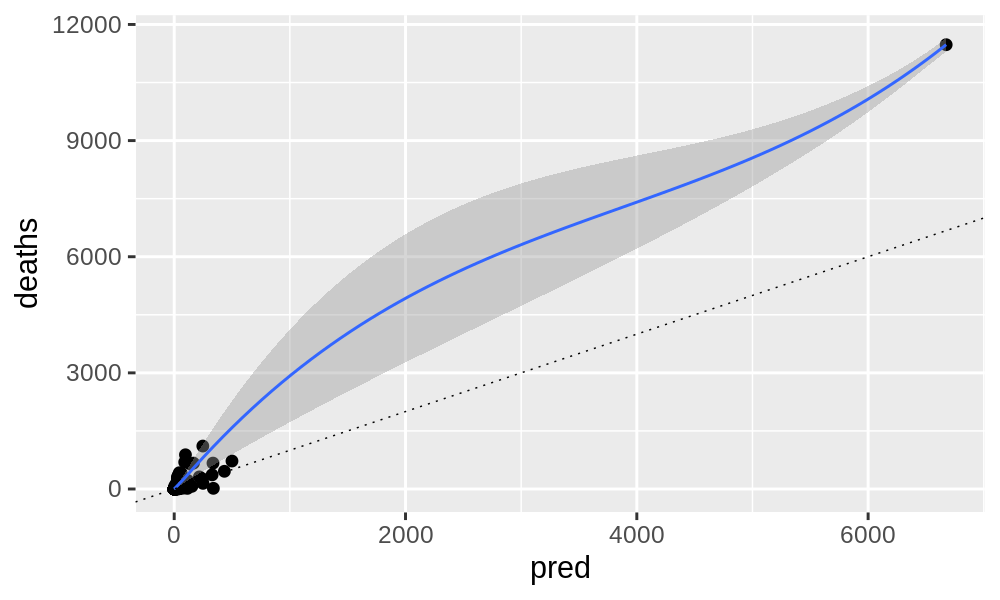

In [38]:
%%R -i exam -w 5 -h 3 --units in -r 200
library(ggplot2)
ggplot(exam, aes(x=pred, y=deaths)) + geom_jitter() + 
geom_smooth(method = "loess", size = 0.5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



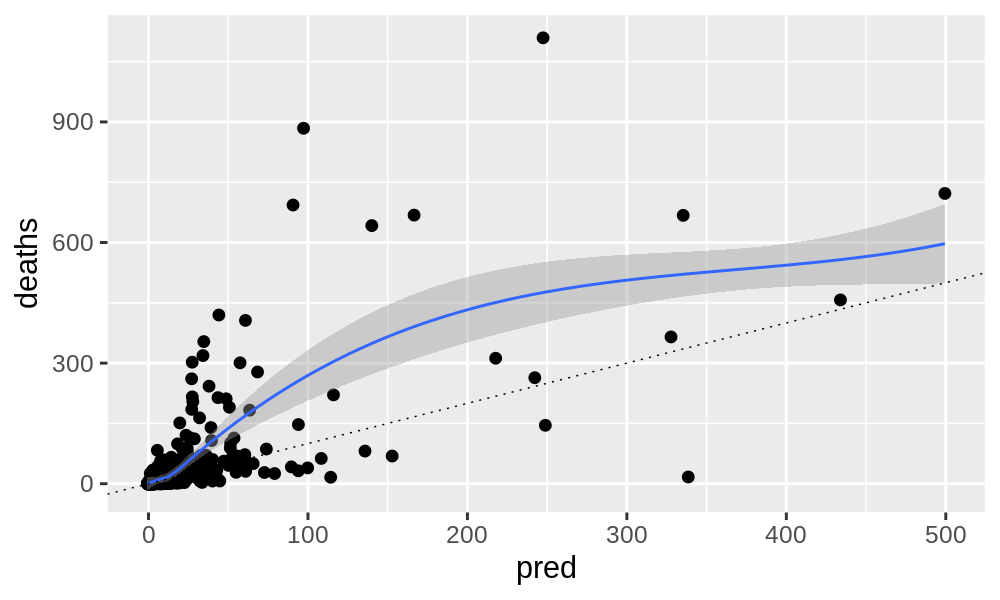

In [32]:
%%R -w 5 -h 3 --units in -r 200

ggplot(exam[exam$count != "New York County",], aes(x=pred, y=deaths)) + geom_jitter() + 
geom_smooth(method = "loess", size = .5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



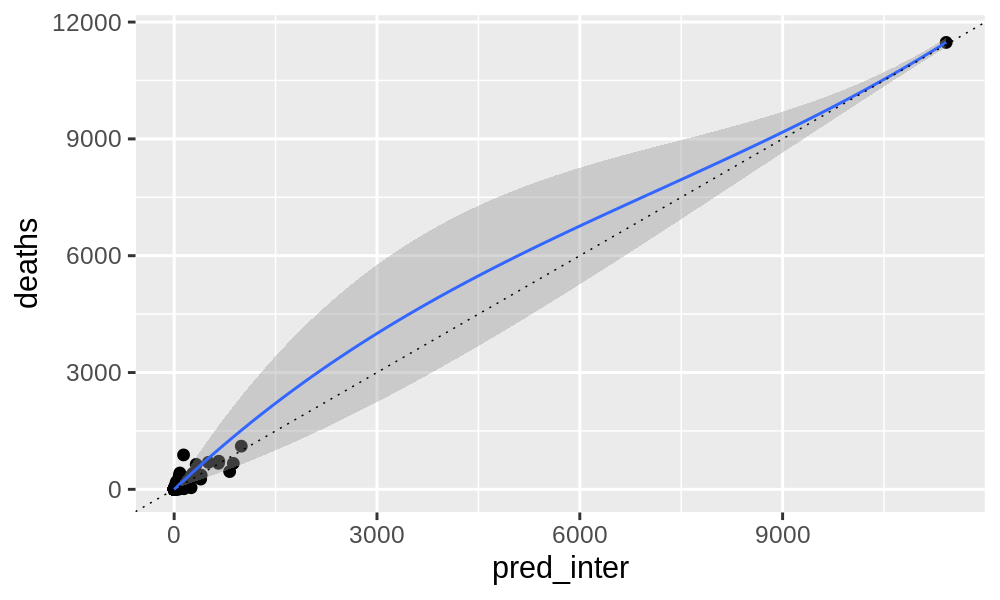

In [34]:
%%R -w 5 -h 3 --units in -r 200

ggplot(exam, aes(x=pred_inter, y=deaths)) + geom_jitter() + 
geom_smooth(method = "loess", size = .5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



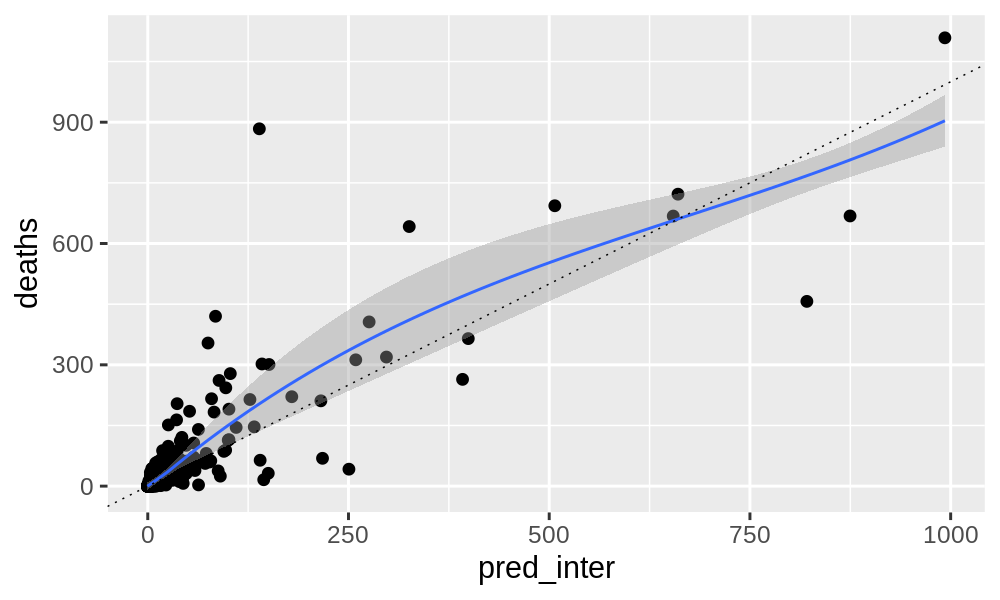

In [37]:
%%R -w 5 -h 3 --units in -r 200

ggplot(exam[exam$county != "New York County",], aes(x=pred_inter, y=deaths)) + geom_jitter() + 
geom_smooth(method = "loess", size = .5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

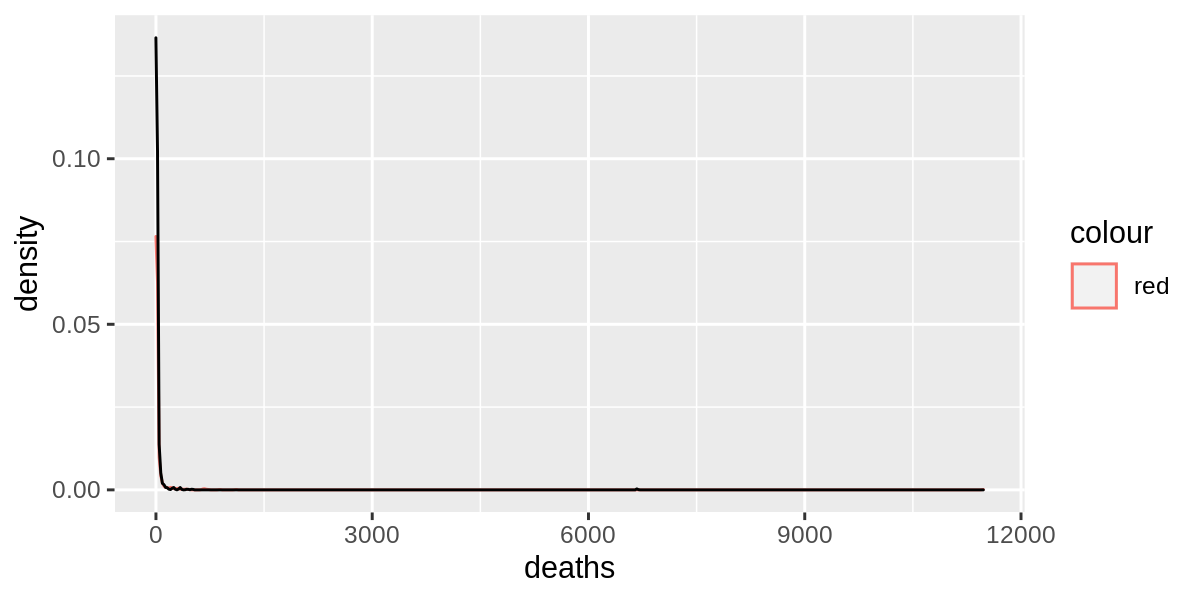

In [39]:
%%R -w 6 -h 3 --units in -r 200

ggplot(exam) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

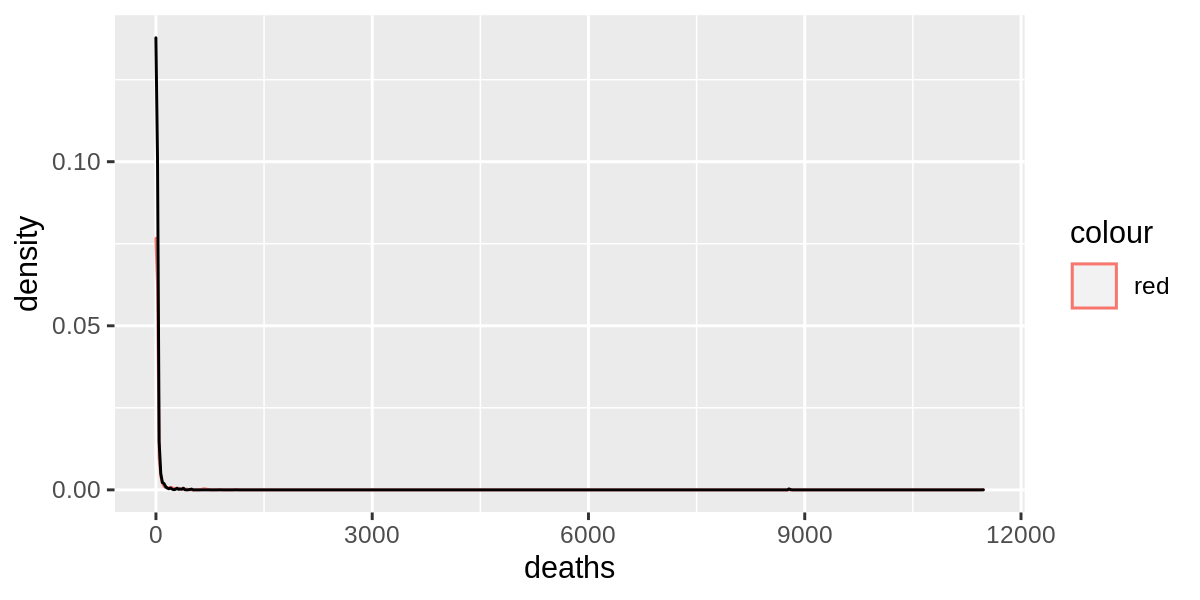

In [678]:
%%R -i exam -w 6 -h 3 --units in -r 200

ggplot(exam) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

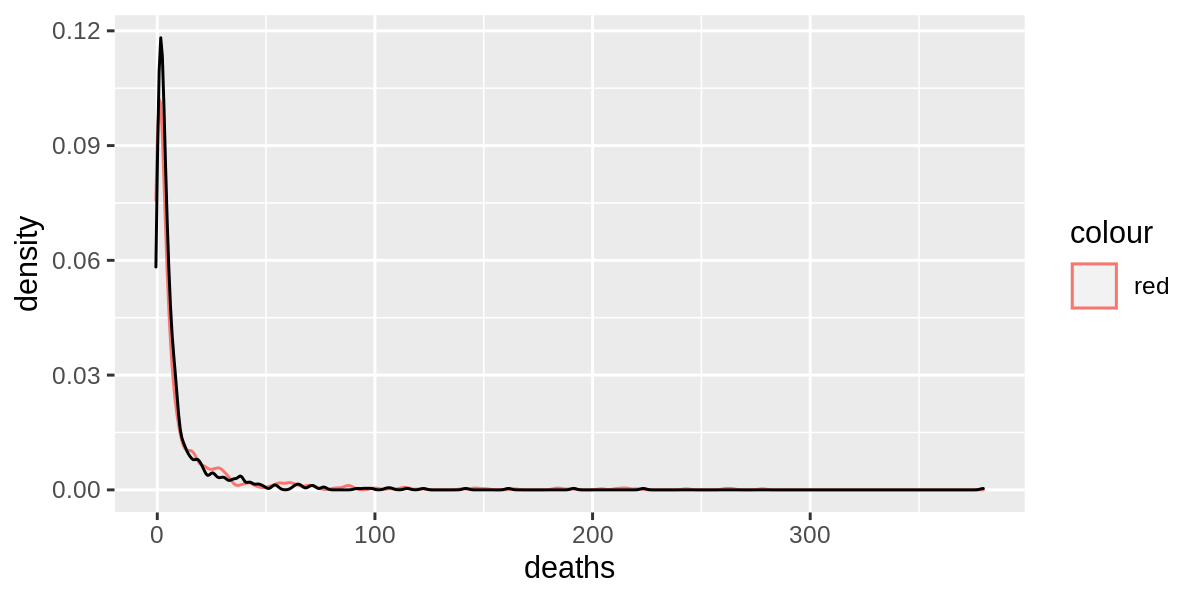

In [679]:
%%R -i exam -w 6 -h 3 --units in -r 200

ggplot(exam[exam$deaths < 300,]) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

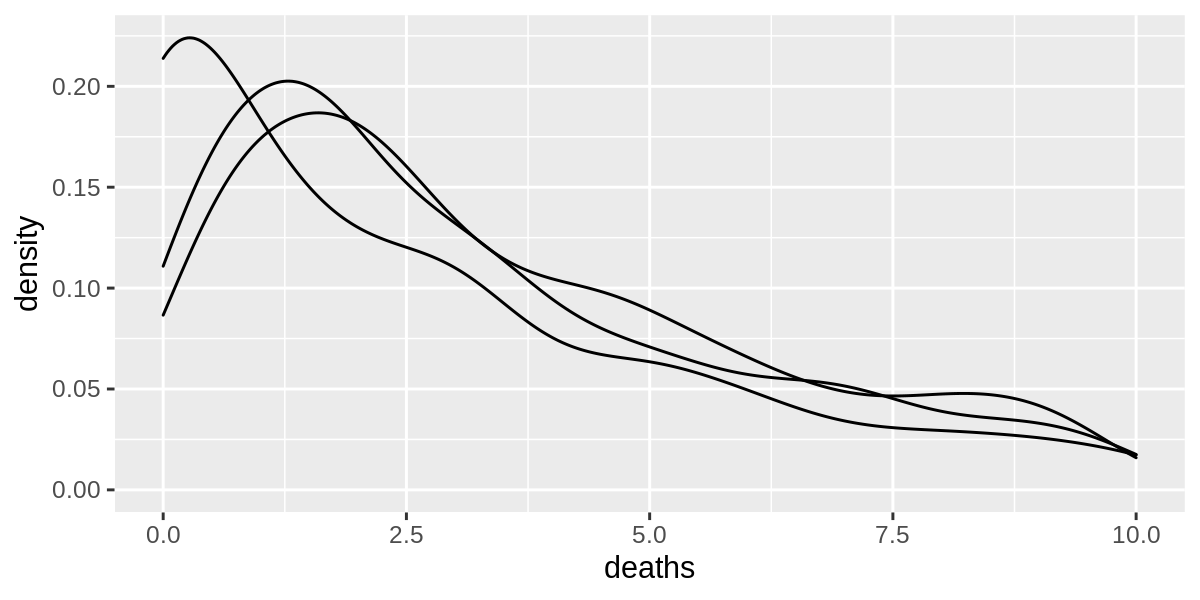

In [54]:
%%R -i exam -w 6 -h 3 --units in -r 200

ggplot(exam) + geom_density(aes(deaths)) + geom_density(aes(pred)) + geom_density(aes(pred_inter)) +
xlim(0,10)

In [55]:
# check the model using R-style plots
# https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
# https://medium.com/@vikashrajluhaniwal/simulating-replicating-r-regression-plot-in-python-using-sklearn-4ee48a15b67

import seaborn as sns
import matplotlib.pyplot as plt
#import scipy.stats as stats

#import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [56]:
exam["residuals"] = exam["deaths"] - exam["pred"]
exam["residuals_inter"] = exam["deaths"] - exam["pred_inter"]

In [57]:
exam[["residuals", "residuals_inter", "deaths", "pred", "pred_inter"]].describe()

,residuals,residuals_inter,deaths,pred,pred_inter
count,823.000000,823.000000,823.000000,823.000000,823.000000
mean,16.742816,5.136325,38.071689,21.328873,32.935364
std,179.438778,43.534565,408.374275,235.360215,404.262825
min,-321.488066,-363.909555,0.000000,-0.692413,-0.454685
25%,-2.027777,-1.538167,1.000000,1.545885,1.316806
50%,0.019872,-0.035912,3.000000,3.783330,3.377938
75%,2.976966,2.313117,13.000000,9.147288,9.222401
max,4802.103984,745.038338,11477.000000,6674.896016,11419.347956


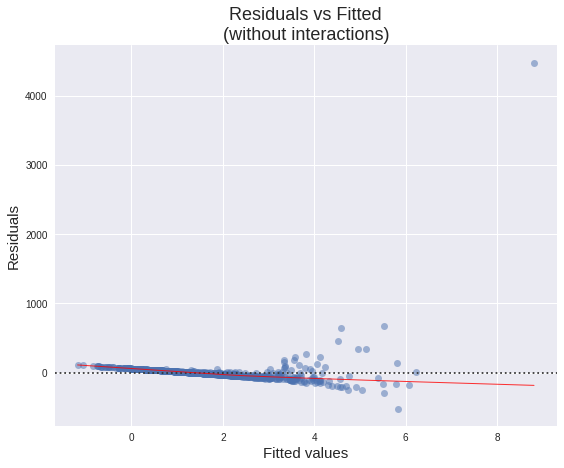

In [58]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam["fitted"], exam["residuals"], data=exam,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(without interactions)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

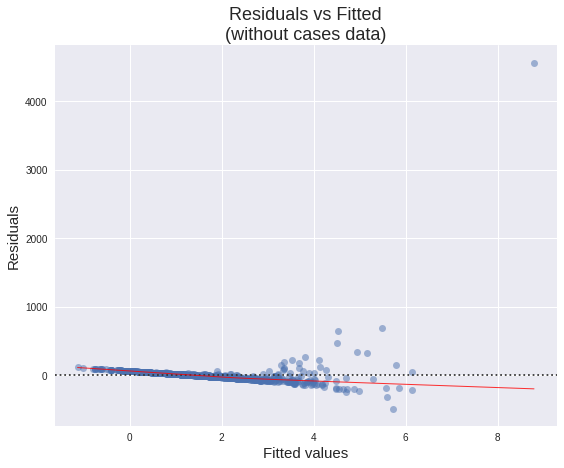

In [629]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam["fitted_noCases"], exam["residuals_noCases"], data=exam,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(without cases data)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

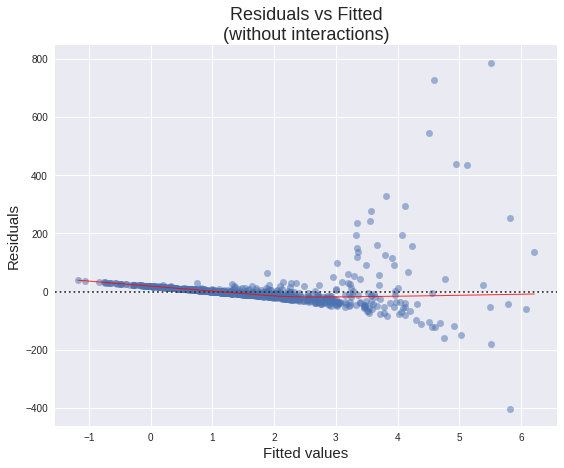

In [59]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam.loc[exam["deaths"]<5000,"fitted"], 
                                  exam.loc[exam["deaths"]<5000,"residuals"], 
                                  data=exam.loc[exam["deaths"]<5000,],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(without interactions)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# looking at the same (still heterskedasticitic) when removing NY County (a spectacular outlier)

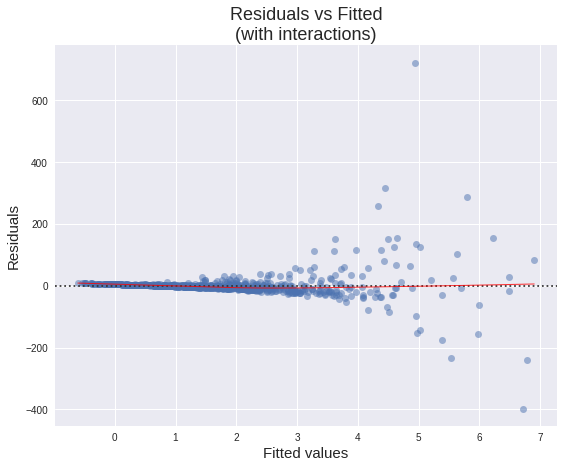

In [60]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam.loc[exam["deaths"]<5000,"fitted_inter"], 
                                  exam.loc[exam["deaths"]<5000,"residuals_inter"], 
                                  data=exam.loc[exam["deaths"]<5000,],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(with interactions)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# same sort of heteroskedasticity as with case data

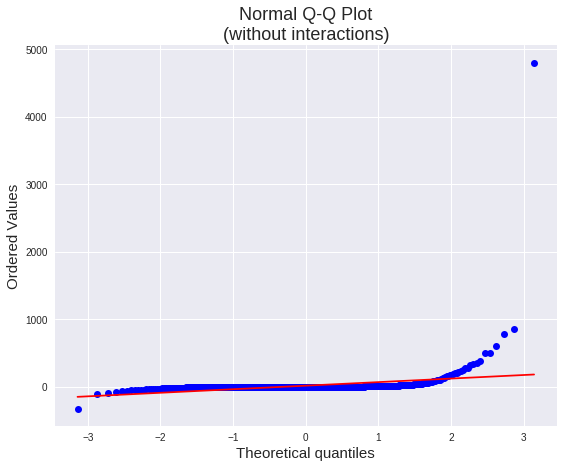

In [62]:
plt.figure(figsize=(9,7))
stats.probplot(exam["residuals"], dist="norm", 
                                   plot=plt)

plt.title('Normal Q-Q Plot\n(without interactions)');

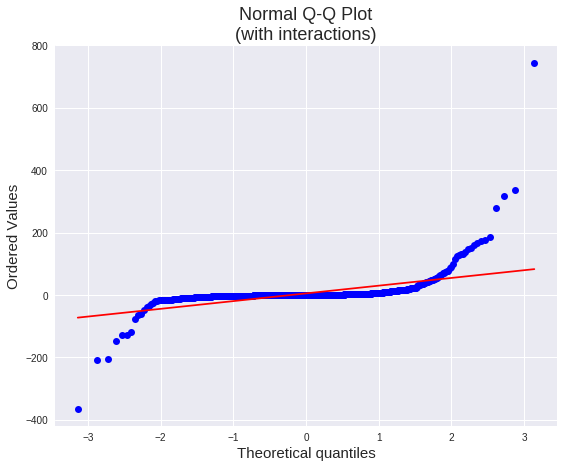

In [63]:
plt.figure(figsize=(9,7))
stats.probplot(exam["residuals_inter"], dist="norm", 
                                   plot=plt)

plt.title('Normal Q-Q Plot\n(with interactions)');

Text(0.5, 0, 'Fitted value')

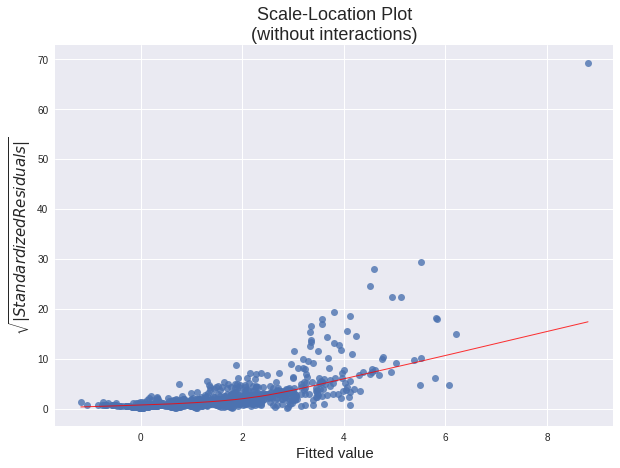

In [64]:
exam["norm_residuals_abs_sqrt"]=np.sqrt(np.abs(exam["residuals"]))

plt.figure(figsize=(10,7))
sns.regplot(exam["fitted"], exam["norm_residuals_abs_sqrt"],
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title("Scale-Location Plot\n(without interactions)")
plt.ylabel("$\sqrt{|Standardized Residuals|}$")
plt.xlabel("Fitted value")

Text(0.5, 0, 'Fitted value')

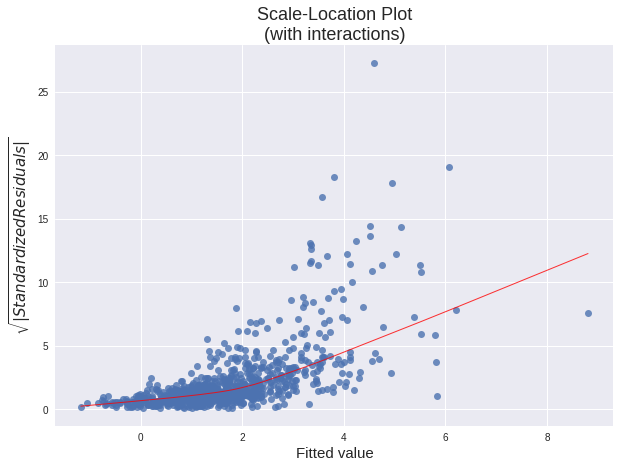

In [65]:
exam["norm_residuals_abs_sqrt"]=np.sqrt(np.abs(exam["residuals_inter"]))

plt.figure(figsize=(10,7))
sns.regplot(exam["fitted"], exam["norm_residuals_abs_sqrt"],
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title("Scale-Location Plot\n(with interactions)")
plt.ylabel("$\sqrt{|Standardized Residuals|}$")
plt.xlabel("Fitted value")

### Elastic Net

In [145]:
x_data = [abbrev[predictors_noCaseData], abbrev[predictors], abbrev[log_predictors_noCaseData], abbrev[log_predictors],  
          inter_noCases, inter, inter_log_noCases,  inter_log]
labels = ["no case data", "with case data", "log predictors, no case data", "log predictors, with case data", 
          "no case data, with interactions", "with case data, with interactions", 
          "log predictors, no case data, with interactions", "log predictors, with case data, with interactions"]

In [220]:
results_cv10 = list()
ratios = [0.1,0.3,0.5, 0.7, 0.9, 1.0]

# couldn't get the for loop to instantiate new regressors
ttr_encv1 = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, max_iter=6000, l1_ratio=0.1, random_state=1001, cv=10), 
                                          func=np.log1p, inverse_func=np.expm1)
ttr_encv3 = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, max_iter=6000, l1_ratio=0.3, random_state=1001, cv=10), 
                                          func=np.log1p, inverse_func=np.expm1)
ttr_encv5 = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, max_iter=6000, l1_ratio=0.5, random_state=1001, cv=10), 
                                          func=np.log1p, inverse_func=np.expm1)
ttr_encv7 = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, max_iter=6000, l1_ratio=0.7, random_state=1001, cv=10), 
                                          func=np.log1p, inverse_func=np.expm1)
ttr_encv9 = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, max_iter=6000, l1_ratio=0.9, random_state=1001, cv=10), 
                                          func=np.log1p, inverse_func=np.expm1)
ttr_encv10 = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, max_iter=6000, l1_ratio=1.0, random_state=1001, cv=10), 
                                          func=np.log1p, inverse_func=np.expm1)


regressors = [ttr_encv1, ttr_encv3, ttr_encv5, ttr_encv7, ttr_encv9, ttr_encv10]
for ratio, regressor in zip(ratios, regressors):
    print("l1-ratio = {:.1f}".format(ratio))
    print("{:50} {:>10} {:>10} {:>10}".format("dataset", "R2", "RMSE", "MdAE"))
    predictions = list()
    
    for dataset in x_data:
        regressor.fit(dataset, abbrev["deaths"])
        scores.append(regressor.score(dataset, abbrev["deaths"]))
        predictions.append(regressor.inverse_func(regressor.regressor_.predict(dataset)))

    for a, b in zip(labels, predictions):
        print("{:50} {:10.3f} {:10.1f} {:10.1f}".format(a, r2_score(abbrev["deaths"], b), 
                                                        np.sqrt(mean_squared_error(abbrev["deaths"], b)),
                                                        median_absolute_error(abbrev["deaths"], b)))
    print()

l1-ratio = 0.1
dataset                                                    R2       RMSE       MdAE
no case data                                           -5.467     1037.9        2.4
with case data                                        -22.270     1968.8        2.4
log predictors, no case data                            0.425      309.4        2.4
log predictors, with case data                          0.554      272.4        2.3
no case data, with interactions                         0.949       91.9        2.2
with case data, with interactions                       0.909      123.2        2.2
log predictors, no case data, with interactions         0.850      157.8        2.1
log predictors, with case data, with interactions       0.591      261.0        2.1

l1-ratio = 0.3
dataset                                                    R2       RMSE       MdAE
no case data                                           -8.853     1281.1        2.4
with case data                               

In [225]:
# look at models using log predictors, no case data, with interactions using l1_ratio = 1.0, 0.9, and 0.7
ttr_encv10.fit(inter_log_noCases, abbrev["deaths"])
print("l1_ratio = 1.0")
print("variables with coeff==0: ", len(ttr_encv10.regressor_.coef_[ttr_encv10.regressor_.coef_ == 0.0]))
print("variables with non-zero coeff: ", len(ttr_encv10.regressor_.coef_[ttr_encv10.regressor_.coef_ != 0.0]))
print()

ttr_encv9.fit(inter_log_noCases, abbrev["deaths"])
print("l1_ratio = 0.9")
print("variables with coeff==0: ", len(ttr_encv9.regressor_.coef_[ttr_encv9.regressor_.coef_ == 0.0]))
print("variables with non-zero coeff: ", len(ttr_encv9.regressor_.coef_[ttr_encv9.regressor_.coef_ != 0.0]))
print()

ttr_encv7.fit(inter_log_noCases, abbrev["deaths"])
print("l1_ratio = 0.9")
print("variables with coeff==0: ", len(ttr_encv7.regressor_.coef_[ttr_encv7.regressor_.coef_ == 0.0]))
print("variables with non-zero coeff: ", len(ttr_encv7.regressor_.coef_[ttr_encv7.regressor_.coef_ != 0.0]))
# l1_ratio=1.0 is MUCH more parsimonious

l1_ratio = 1.0
variables with coeff==0:  159
variables with non-zero coeff:  51

l1_ratio = 0.9
variables with coeff==0:  129
variables with non-zero coeff:  81

l1_ratio = 0.9
variables with coeff==0:  100
variables with non-zero coeff:  110


In [226]:
ttr_encv10_b = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, max_iter=6000, l1_ratio=1.0, random_state=1001, cv=10), 
                                          func=np.log1p, inverse_func=np.expm1)
ttr_encv10_b.fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])
print("l1_ratio = 1.0, no interactions")
print("variables with coeff==0: ", len(ttr_encv10_b.regressor_.coef_[ttr_encv10_b.regressor_.coef_ == 0.0]))
print("variables with non-zero coeff: ", len(ttr_encv10_b.regressor_.coef_[ttr_encv10_b.regressor_.coef_ != 0.0]))
print()

# from ttr_encv10, fitted above
print("l1_ratio = 1.0, with interactions")
print("variables with coeff==0: ", len(ttr_encv10.regressor_.coef_[ttr_encv10.regressor_.coef_ == 0.0]))
print("variables with non-zero coeff: ", len(ttr_encv10.regressor_.coef_[ttr_encv10.regressor_.coef_ != 0.0]))

l1_ratio = 1.0, no interactions
variables with coeff==0:  6
variables with non-zero coeff:  14

l1_ratio = 1.0, with interactions
variables with coeff==0:  159
variables with non-zero coeff:  51


In [232]:
coeffs = dict()

for a, b in zip(log_predictors_noCaseData, ttr_encv10_b.regressor_.coef_):
    if b not in coeffs.keys() and b != 0:
        coeffs[b] = a
    elif b in coeffs.keys():
        print("collsion: ", a, "\t", b)

coeffs = sorted(coeffs.items(), reverse=True)
i = 1
for pair in coeffs:
    print('{:2} {:30}{:>8.4f}'.format(i, pair[1], pair[0]))
    i = i+1

 1 log_population                  0.5700
 2 log_density                     0.1428
 3 ten_plus                        0.0730
 4 prc_public_transp               0.0491
 5 pop_65_plus                     0.0278
 6 prc_fam_poverty                 0.0248
 7 order                           0.0214
 8 health_ins                      0.0185
 9 prc_obese                       0.0178
10 log_intl_passengers             0.0100
11 empl_manufacturing              0.0043
12 avg_income                      0.0000
13 empl_professional              -0.0376
14 empl_services                  -0.0381


In [233]:
coeffs = dict()

for a, b in zip(inter_log_noCases.columns, ttr_encv10.regressor_.coef_):
    if b not in coeffs.keys() and b != 0:
        coeffs[b] = a
    elif b in coeffs.keys():
        print("collsion: ", a, "\t", b)

coeffs = sorted(coeffs.items(), reverse=True)
i = 1
for pair in coeffs:
    print('{:2} {:50}{:>8.4f}'.format(i, pair[1], pair[0]))
    i = i+1

 1 ten_plus                                            0.6498
 2 log_population                                      0.3518
 3 log_density                                         0.2332
 4 order                                               0.1536
 5 ten_plus:log_density                                0.1184
 6 prc_fam_poverty                                     0.0989
 7 pop_65_plus                                         0.0886
 8 pop_65_plus:log_density                             0.0874
 9 household_size:prc_public_transp                    0.0801
10 empl_services:log_area                              0.0493
11 ten_plus:log_population                             0.0483
12 empl_social:order                                   0.0449
13 ten_plus:order                                      0.0355
14 household_size:order                                0.0347
15 empl_retail:order                                   0.0326
16 prc_fam_poverty:ten_plus                            0.0318
17 empl_

In [203]:
exam = abbrev.copy()
exam["fitted"] = ttr_encv10.regressor_.predict(inter_log_noCases)
exam["pred"] = ttr_encv10.inverse_func(ttr_encv10.regressor_.predict(inter_log_noCases))

R[write to console]: `geom_smooth()` using formula 'y ~ x'



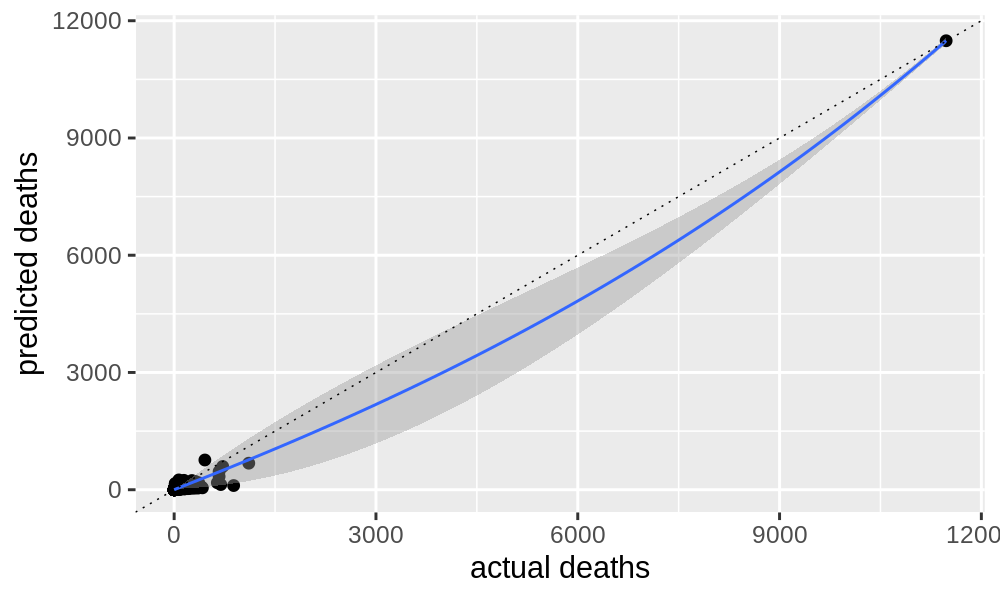

In [208]:
%%R -i exam -w 5 -h 3 --units in -r 200

ggplot(exam, aes(x=deaths, y=pred)) + geom_jitter() + 
geom_smooth(method = "loess", size = 0.5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted") +
xlab("actual deaths") + ylab("predicted deaths")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



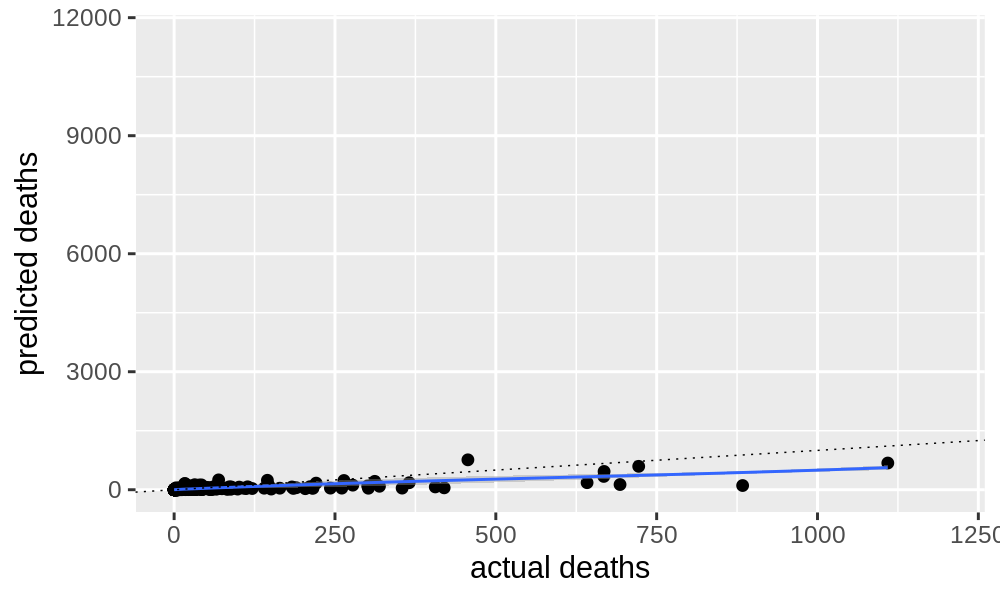

In [213]:
%%R -i exam -w 5 -h 3 --units in -r 200

ggplot(exam, aes(x=deaths, y=pred)) + geom_jitter() + 
geom_smooth(method = "loess", size = 0.5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted") +
xlab("actual deaths") + ylab("predicted deaths") +
xlim(0,1200)

In [216]:
np.square(np.log1p(0.00001))

9.99990000091666e-11

In [217]:
np.expm1(np.sqrt(np.square(np.log1p(0.00001))))

1e-05

In [214]:
exam["residuals"] = exam["deaths"] - exam["pred"]

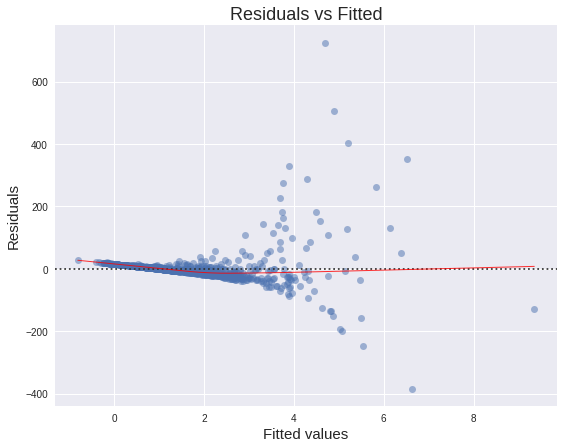

In [215]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam["fitted"], exam["residuals"], data=exam,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# still heteroskedastic

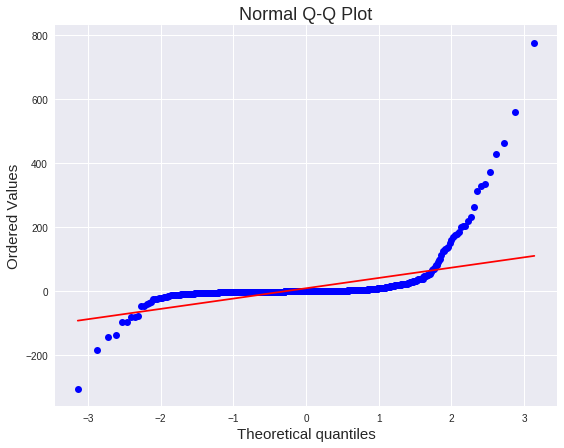

In [218]:
plt.figure(figsize=(9,7))
stats.probplot(exam["residuals"], dist="norm", plot=plt)
plt.title('Normal Q-Q Plot');

Text(0.5, 0, 'Fitted value')

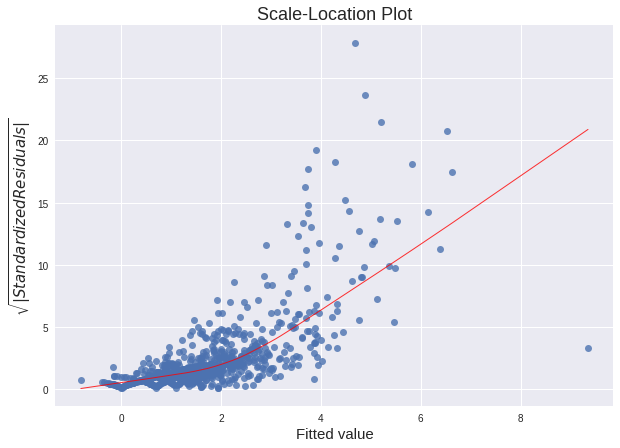

In [219]:
exam["norm_residuals_abs_sqrt"]=np.sqrt(np.abs(exam["residuals"]))

plt.figure(figsize=(10,7))
sns.regplot(exam["fitted"], exam["norm_residuals_abs_sqrt"],
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title("Scale-Location Plot")
plt.ylabel("$\sqrt{|Standardized Residuals|}$")
plt.xlabel("Fitted value")